# MCMC using pymc3 on Beta-bernoulli Model

In [2]:
import pymc3 as pm
import arviz as az


In [3]:
tosses = [
    1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
    0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
    1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
    0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
    0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
    1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
    1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
    0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
    1, 1, 1, 0, 0, 0, 1, 0, 1, 0
]



In [8]:
sum(tosses)

57

In [11]:
with pm.Model() as model:
    # define the prior
    theta = pm.Beta('theta', 4, 4)
    
    # define the likelihood
    data = pm.Bernoulli('data', theta, observed=tosses)
    
    # get the samples
    trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


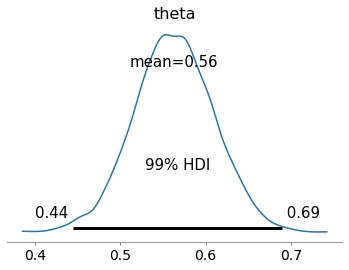

In [12]:
az.plot_posterior(trace, hdi_prob=0.99)

# MCMC and VI using pymc3 on BLR

In [13]:
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano
import warnings
from numpy.random import binomial, randn, uniform
from sklearn.model_selection import train_test_split


In [14]:
%matplotlib inline

sns.set()
warnings.filterwarnings('ignore')

In [15]:
α_0 = 1
α_1 = 1.25

β_0 = 1
β_1 = 1.25

𝜎 = 0.75

,y,x,category
0,5.280876,4.582838,0
1,5.489383,3.807423,1
2,7.679604,4.339340,1
3,6.806240,3.652701,1
4,4.912624,4.410691,0


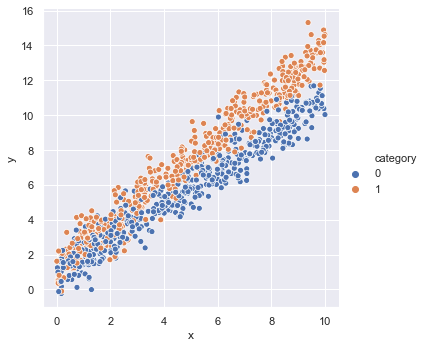

In [16]:
n_samples = 1000

category = binomial(n=1, p=0.5, size=n_samples)
x = uniform(low=0, high=10, size=n_samples)

y = ((1 - category) * α_0 + category * α_1
     + ((1 - category) * β_0 + category * β_1) * x
     + 𝜎 * randn(n_samples))

model_data = pd.DataFrame({'y': y, 'x': x, 'category': category})

display(model_data.head())
_ = sns.relplot(x='x', y='y', hue='category', data=model_data)

In [17]:
train, test = train_test_split(
    model_data, test_size=0.2, stratify=model_data.category)

In [18]:
y_tensor = theano.shared(train.y.values.astype('float64'))
x_tensor = theano.shared(train.x.values.astype('float64'))
cat_tensor = theano.shared(train.category.values.astype('int64'))

In [19]:
with pm.Model() as model:
    α_prior = pm.HalfNormal('α', sd=2, shape=2)
    β_prior = pm.Normal('β', mu=0, sd=2, shape=2)
    𝞂_prior = pm.HalfNormal('𝞂', sd=2, shape=1)
    μ_likelihood = α_prior[cat_tensor] + β_prior[cat_tensor] * x_tensor
    y_likelihood = pm.Normal('y', mu=μ_likelihood, sd=𝞂_prior, observed=y_tensor)

In [21]:
with model:
    hmc_trace = pm.sample(draws=5000, tune=1000, cores=6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [𝞂, β, α]


Sampling 6 chains for 1_000 tune and 5_000 draw iterations (6_000 + 30_000 draws total) took 27 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β[0],0.980,0.014,0.955,1.006,0.000,0.0,16887.0,17204.0,1.0
β[1],1.232,0.013,1.208,1.256,0.000,0.0,17361.0,17902.0,1.0
α[0],1.041,0.075,0.900,1.180,0.001,0.0,17066.0,16757.0,1.0
α[1],1.339,0.073,1.205,1.476,0.001,0.0,16656.0,17522.0,1.0
𝞂[0],0.759,0.019,0.723,0.796,0.000,0.0,23977.0,19627.0,1.0


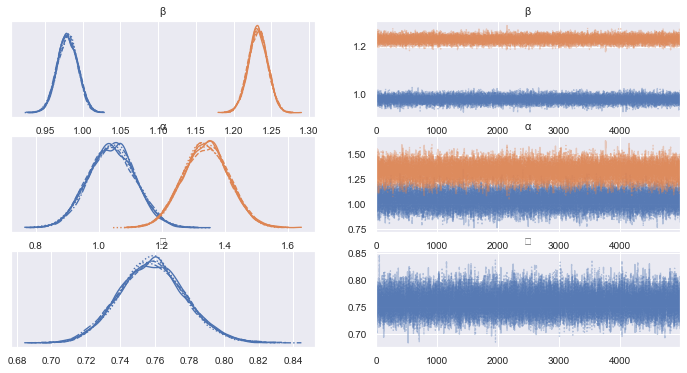

In [22]:
pm.traceplot(hmc_trace)
pm.summary(hmc_trace)

In [23]:
map_tensor_batch = {y_tensor: pm.Minibatch(train.y.values, 100),
                    x_tensor: pm.Minibatch(train.x.values, 100),
                    cat_tensor: pm.Minibatch(train.category.values, 100)}

In [24]:
with model:
    advi_fit = pm.fit(method=pm.ADVI(), n=30000,
                      more_replacements=map_tensor_batch)

Finished [100%]: Average Loss = 131.49


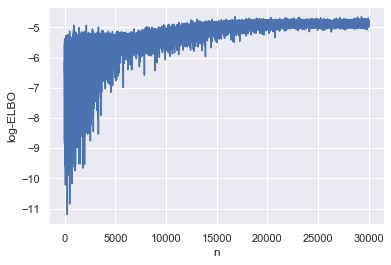

In [25]:
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β[0],0.976,0.023,0.933,1.020,0.000,0.000,9930.0,9385.0,NaN
β[1],1.233,0.022,1.191,1.273,0.000,0.000,9924.0,9427.0,NaN
α[0],1.034,0.127,0.805,1.277,0.001,0.001,9852.0,9719.0,NaN
α[1],1.330,0.126,1.103,1.576,0.001,0.001,9864.0,9020.0,NaN
𝞂[0],0.787,0.063,0.672,0.908,0.001,0.000,10168.0,9879.0,NaN


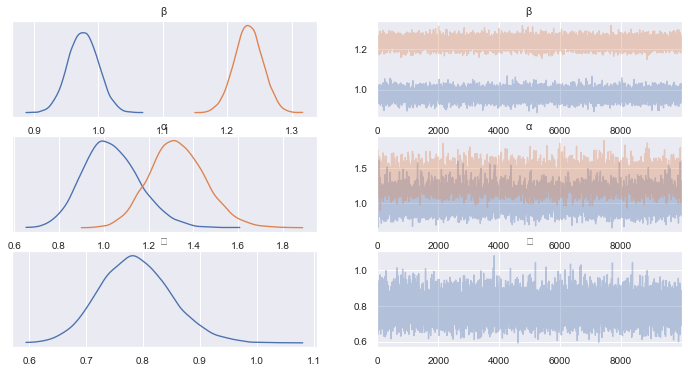

In [26]:
advi_trace = advi_fit.sample(10000)
pm.traceplot(advi_trace)
pm.summary(advi_trace)

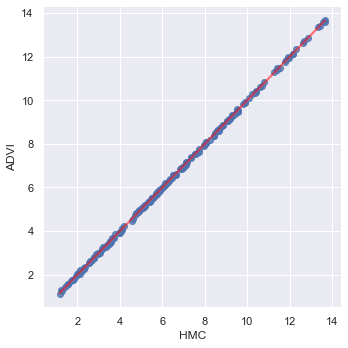

In [29]:

y_tensor.set_value(test.y.values)
x_tensor.set_value(test.x.values)
cat_tensor.set_value(test.category.values.astype('int64'))

hmc_posterior_pred =  pm.sample_posterior_predictive (hmc_trace, 1000, model)
hmc_predictions = np.mean(hmc_posterior_pred['y'], axis=0)

advi_posterior_pred =  pm.sample_posterior_predictive(advi_trace, 1000, model)
advi_predictions = np.mean(advi_posterior_pred['y'], axis=0)

prediction_data = pd.DataFrame(
    {'HMC': hmc_predictions, 
     'ADVI': advi_predictions, 
     'actual': test.y,
     'error_HMC': hmc_predictions - test.y, 
     'error_ADVI': advi_predictions - test.y})

_ = sns.lmplot(y='ADVI', x='HMC', data=prediction_data,
               line_kws={'color': 'red', 'alpha': 0.5})

In [30]:
prediction_data

,HMC,ADVI,actual,error_HMC,error_ADVI
207,2.319475,2.295712,-0.014826,2.334300,2.310538
924,5.198591,5.173509,5.723429,-0.524838,-0.549920
297,5.513957,5.500647,5.094608,0.419349,0.406039
333,4.201754,4.217563,4.353236,-0.151482,-0.135673
880,12.875597,12.844792,13.943994,-1.068398,-1.099203
...,...,...,...,...,...
74,13.411580,13.388038,14.042010,-0.630429,-0.653972
838,3.016768,3.000973,3.098863,-0.082094,-0.097889
875,12.623980,12.623480,12.574246,0.049734,0.049235
577,2.952851,2.961844,3.594830,-0.641979,-0.632986


# BNN VI using PYMC3

In [31]:
from warnings import filterwarnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import sklearn
import theano
import theano.tensor as T

from sklearn import datasets
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.5


In [32]:
%config InlineBackend.figure_format = 'retina'
floatX = theano.config.floatX
filterwarnings("ignore")
sns.set_style("white")

In [33]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

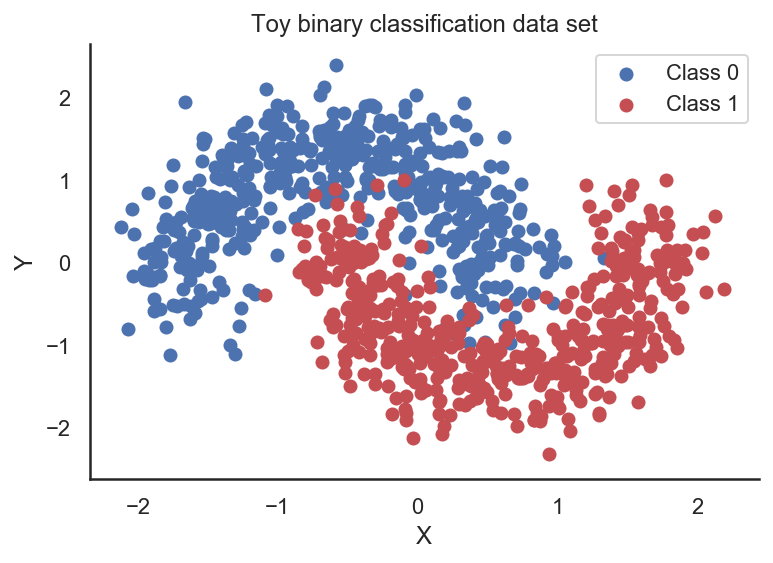

In [34]:
fig, ax = plt.subplots()
ax.scatter(X[Y == 0, 0], X[Y == 0, 1], label="Class 0")
ax.scatter(X[Y == 1, 0], X[Y == 1, 1], color="r", label="Class 1")
sns.despine()
ax.legend()
ax.set(xlabel="X", ylabel="Y", title="Toy binary classification data set");

In [35]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data("ann_input", X_train)
        ann_output = pm.Data("ann_output", Y_train)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal("w_in_1", 0, sigma=1, shape=(X.shape[1], n_hidden), testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal("w_1_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, shape=(n_hidden,), testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli(
            "out",
            act_out,
            observed=ann_output,
            total_size=Y_train.shape[0],  # IMPORTANT for minibatches
        )
    return neural_network


neural_network = construct_nn(X_train, Y_train)

In [38]:
from pymc3.theanof import MRG_RandomStreams, set_tt_rng

set_tt_rng(MRG_RandomStreams(42))

ImportError: cannot import name 'MRG_RandomStreams' from 'pymc3.theanof' (/Users/diptarka/opt/anaconda3/lib/python3.7/site-packages/pymc3/theanof.py)

In [39]:
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference)

Finished [100%]: Average Loss = 155.69


In [40]:
trace = approx.sample(draws=5000)

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"w_in_1[0, 0]",0.562,0.136,0.313,0.821,0.002,0.001,5121.0,4395.0,NaN
"w_in_1[0, 1]",-0.264,0.531,-1.265,0.708,0.008,0.005,4793.0,4699.0,NaN
"w_in_1[0, 2]",0.580,0.068,0.457,0.712,0.001,0.001,4924.0,5106.0,NaN
"w_in_1[0, 3]",3.492,0.437,2.665,4.298,0.006,0.004,4987.0,4872.0,NaN
"w_in_1[0, 4]",0.275,0.352,-0.387,0.925,0.005,0.004,4791.0,4937.0,NaN
"w_in_1[1, 0]",-0.288,0.180,-0.607,0.065,0.003,0.002,4463.0,4812.0,NaN
"w_in_1[1, 1]",-0.291,0.529,-1.282,0.693,0.007,0.005,5227.0,4752.0,NaN
"w_in_1[1, 2]",-0.319,0.100,-0.515,-0.142,0.001,0.001,5074.0,4901.0,NaN
"w_in_1[1, 3]",0.475,0.300,-0.100,1.017,0.004,0.003,4794.0,4800.0,NaN
"w_in_1[1, 4]",0.076,0.412,-0.697,0.826,0.006,0.004,5203.0,4612.0,NaN


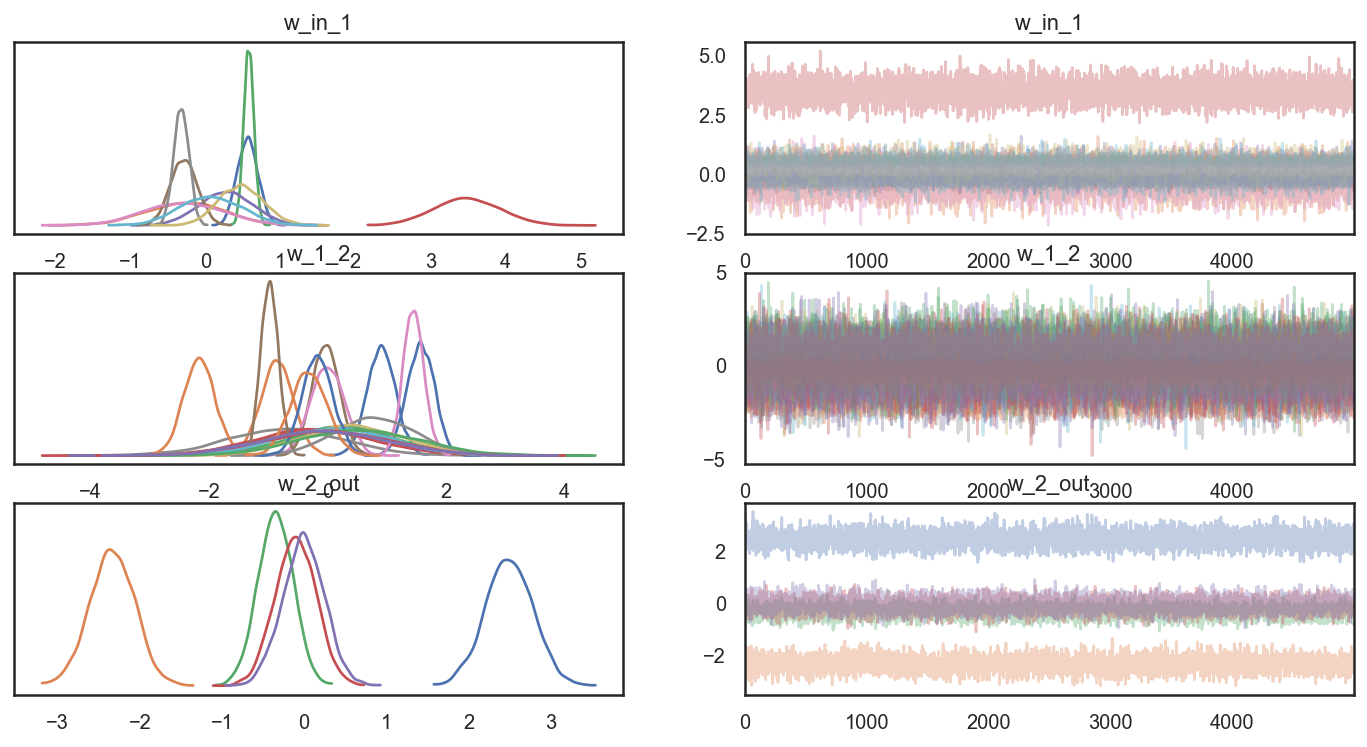

In [41]:
pm.traceplot(trace)
pm.summary(trace)

In [42]:
neural_network.out.distribution.p

sigmoid.0